In [11]:
import pm4py
import pandas

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog

# Read and combine the two log files into one log
log_part_1 = xes_importer.apply("Road_Traffic_Fine_Management_Process_Data/Road_Traffic_Fine_Management_Process_Part1.xes")
log_part_2 = xes_importer.apply("Road_Traffic_Fine_Management_Process_Data/Road_Traffic_Fine_Management_Process_Part2.xes")
log = EventLog(list(log_part_1) + list(log_part_2))
log_df = pm4py.convert_to_dataframe(log)



parsing log, completed traces ::   0%|          | 0/75185 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/75185 [00:00<?, ?it/s]

In [19]:
import numpy as np

# Sort the DataFrame
log_df = log_df.sort_values(['case:concept:name', 'time:timestamp'])

# Add columns for the (1) previous event, (2) next event, (3) time to the next event, and (4) count of previous events
log_df['prev_event'] = np.nan
log_df['next_event'] = np.nan
log_df['time_to_next_event'] = np.nan
log_df['prev_event_count'] = 0

# Group by case ID (trace)
grouped_by_trace = log_df.groupby('case:concept:name')

# Iterate over each trace
for case_id, events in grouped_by_trace:
    # Initialize event count
    event_count = 0

    for i in range(len(events)):
        current_event_index = events.index[i]
        
        # Handle prev_event and prev_event_count
        if i > 0:  # Not the first event
            prev_event_index = events.index[i - 1]
            log_df.at[current_event_index, 'prev_event'] = log_df.at[prev_event_index, 'concept:name']
        log_df.at[current_event_index, 'prev_event_count'] = event_count

        # Handle next_event and time_to_next_event
        if i < len(events) - 1:  # Not the last event
            next_event_index = events.index[i + 1]
            log_df.at[current_event_index, 'next_event'] = log_df.at[next_event_index, 'concept:name']
            
            time_diff = (log_df.at[next_event_index, 'time:timestamp'] - log_df.at[current_event_index, 'time:timestamp']).total_seconds()
            log_df.at[current_event_index, 'time_to_next_event'] = time_diff

        # Increment the event count
        event_count += 1

# Verify the result
print(log_df.head(10))

   amount org:resource dismissal                concept:name vehicleClass  \
0    35.0          561       NIL                 Create Fine            A   
1     NaN          NaN       NaN                   Send Fine          NaN   
2    35.0          561       NIL                 Create Fine            A   
3     NaN          NaN       NaN                   Send Fine          NaN   
4     NaN          NaN       NaN    Insert Fine Notification          NaN   
5    71.5          NaN       NaN                 Add penalty          NaN   
6     NaN          NaN       NaN  Send for Credit Collection          NaN   
7    36.0          561       NIL                 Create Fine            A   
8     NaN          NaN       NaN                   Send Fine          NaN   
9     NaN          NaN       NaN    Insert Fine Notification          NaN   

   totalPaymentAmount lifecycle:transition            time:timestamp  article  \
0                 0.0             complete 2006-07-24 00:00:00+00:00   

In [42]:
# Step 2: Group by 'concept:name' to separate each event type
grouped_by_event = log_df.groupby('concept:name')

for key, event_log in grouped_by_event:
    print(key)
    print(event_log.head(3), "\n")

Add penalty
    amount org:resource dismissal concept:name vehicleClass  \
5     71.5          NaN       NaN  Add penalty          NaN   
10    74.0          NaN       NaN  Add penalty          NaN   
16    74.0          NaN       NaN  Add penalty          NaN   

    totalPaymentAmount lifecycle:transition            time:timestamp  \
5                  NaN             complete 2007-03-16 00:00:00+00:00   
10                 NaN             complete 2007-10-01 00:00:00+00:00   
16                 NaN             complete 2007-09-23 00:00:00+00:00   

    article  points  ... expense  notificationType lastSent paymentAmount  \
5       NaN     NaN  ...     NaN               NaN      NaN           NaN   
10      NaN     NaN  ...     NaN               NaN      NaN           NaN   
16      NaN     NaN  ...     NaN               NaN      NaN           NaN   

    matricola                  next_event time_to_next_event  \
5         NaN  Send for Credit Collection         64368000.0   
10   

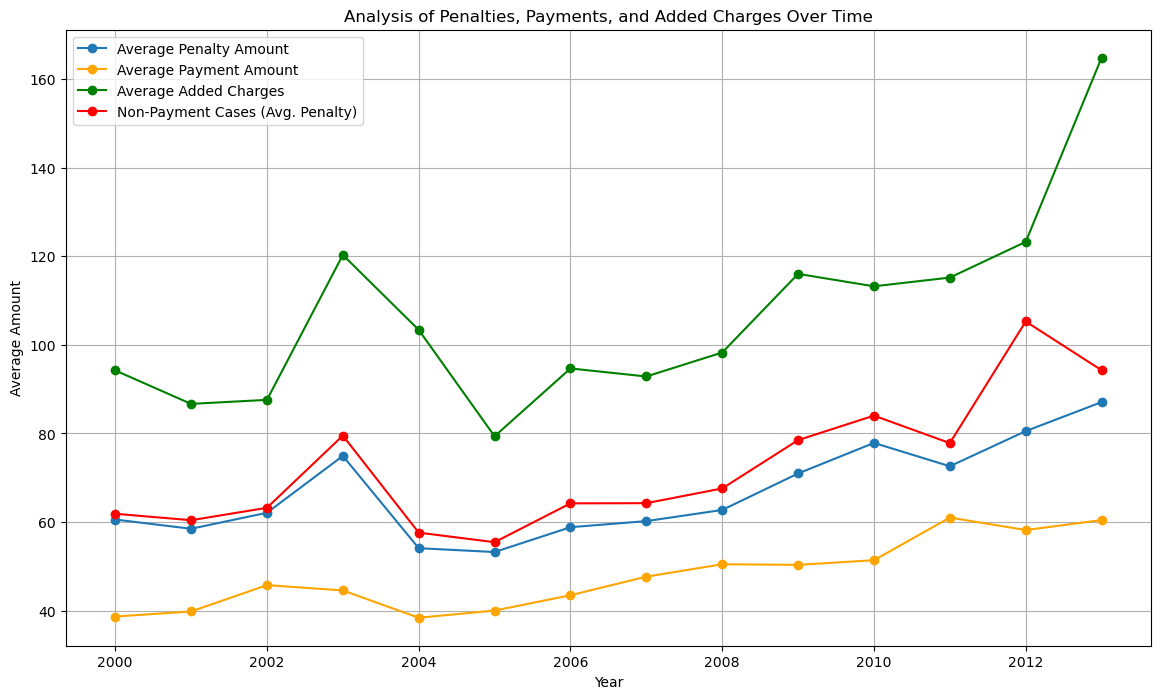

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'time:timestamp' to datetime
log_df['time:timestamp'] = pd.to_datetime(log_df['time:timestamp'])

# Extract year for grouping
log_df['year'] = log_df['time:timestamp'].dt.year

# Group by year and calculate the mean for 'amount' and 'paymentAmount'
yearly_stats = log_df.groupby('year').agg({'amount': 'mean', 'paymentAmount': 'mean'}).reset_index()

# Filter "Add penalty" events and calculate yearly mean of 'amount'
added_charges = log_df[log_df['concept:name'] == 'Add penalty']
added_charges_yearly = added_charges.groupby('year')['amount'].mean().reset_index()

# Filter cases not ending with "Payment" and calculate yearly mean of 'amount'
non_payment_cases = log_df[log_df['next_event'] != 'Payment']
non_payment_yearly = non_payment_cases.groupby('year')['amount'].mean().reset_index()

# Combine with previous yearly statistics
yearly_stats = yearly_stats.merge(
    added_charges_yearly, on='year', how='left', suffixes=('', '_added_charges')
).merge(
    non_payment_yearly, on='year', how='left', suffixes=('', '_non_payment')
)

# Plot all trends
plt.figure(figsize=(14, 8))

# Plot average penalty amount
plt.plot(yearly_stats['year'], yearly_stats['amount'], marker='o', label='Average Penalty Amount')

# Plot average payment amount
plt.plot(yearly_stats['year'], yearly_stats['paymentAmount'], marker='o', color='orange', label='Average Payment Amount')

# Plot average added charges
plt.plot(yearly_stats['year'], yearly_stats['amount_added_charges'], marker='o', color='green', label='Average Added Charges')

# Plot average penalty amount for non-payment cases
plt.plot(yearly_stats['year'], yearly_stats['amount_non_payment'], marker='o', color='red', label='Non-Payment Cases (Avg. Penalty)')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Average Amount')
plt.title('Analysis of Penalties, Payments, and Added Charges Over Time')
plt.legend()
plt.grid()
plt.show()

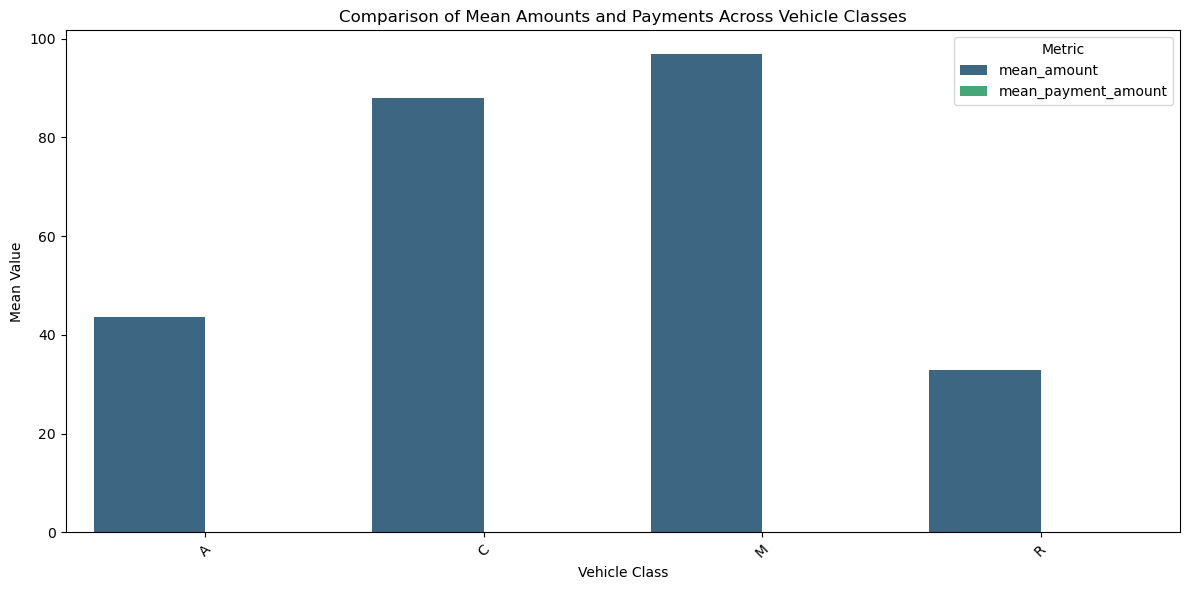

In [44]:
import seaborn as sns
# Filter for A-Class vehicles
# Calculate statistics for each vehicle class
vehicle_class_stats = log_df.groupby('vehicleClass').agg(
    mean_amount=('amount', 'mean'),
    mean_payment_amount=('paymentAmount', 'mean'),
).reset_index()

# Reshape data for plotting (melt for grouped bar plot)
vehicle_class_long = vehicle_class_stats.melt(
    id_vars='vehicleClass',
    value_vars=['mean_amount', 'mean_payment_amount'],
    var_name='Metric',
    value_name='Value'
)

# Separate metrics into two categories: means and missing proportions
vehicle_class_long['Metric_Type'] = vehicle_class_long['Metric'].apply(
    lambda x: 'Mean Values' if 'mean' in x else 'Missing Proportions'
)

# Plot mean values comparison
plt.figure(figsize=(12, 6))
sns.barplot(
    data=vehicle_class_long[vehicle_class_long['Metric_Type'] == 'Mean Values'],
    x='vehicleClass', y='Value', hue='Metric', palette='viridis'
)
plt.title("Comparison of Mean Amounts and Payments Across Vehicle Classes")
plt.ylabel("Mean Value")
plt.xlabel("Vehicle Class")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

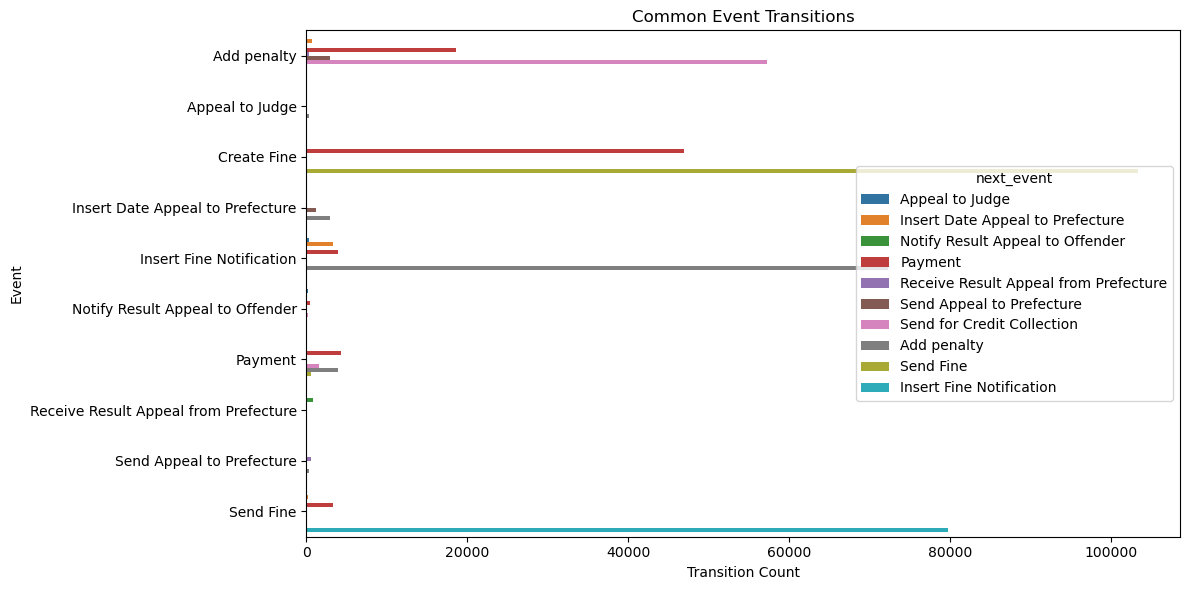

In [56]:
## Prevailing Outcomes
# Ensure necessary columns for event sequence analysis are available
log_df['next_event'] = log_df.groupby('case:concept:name')['concept:name'].shift(-1)

# Count the occurrences of event transitions (e.g., "Create Fine" -> "Send Fine")
transition_counts = log_df.groupby(['concept:name', 'next_event']).size().reset_index(name='count')

# Filter for common transitions (e.g., transitions with more than 50 occurrences)
common_transitions = transition_counts[transition_counts['count'] > 50]

# Plot the most common transitions
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='concept:name', hue='next_event', data=common_transitions)
plt.title("Common Event Transitions")
plt.xlabel("Transition Count")
plt.ylabel("Event")
plt.tight_layout()
plt.show()

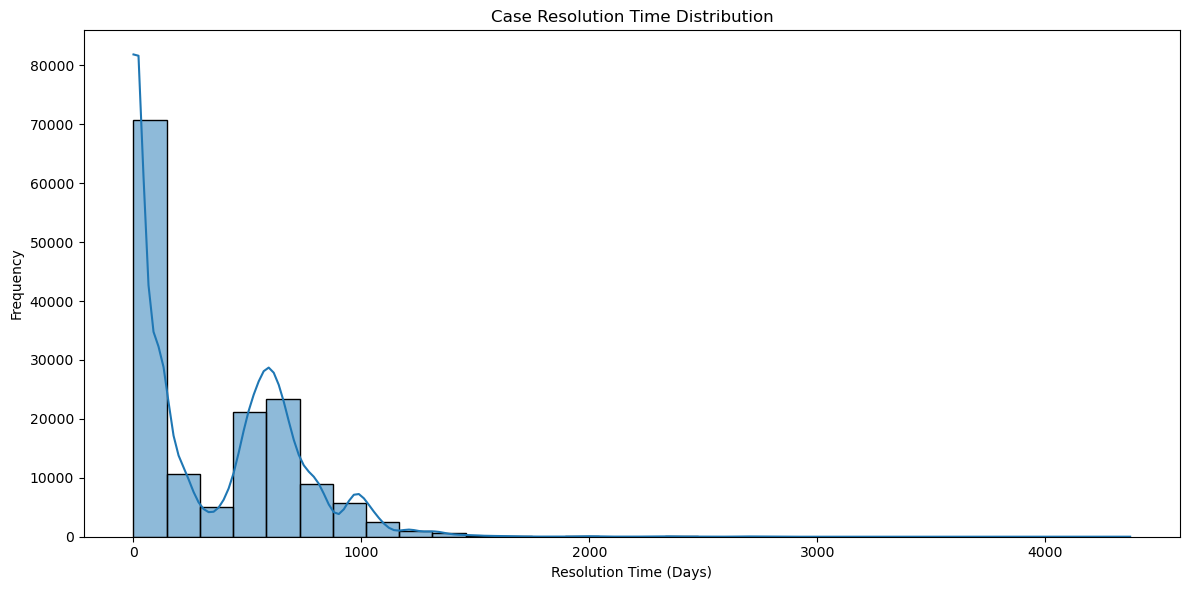

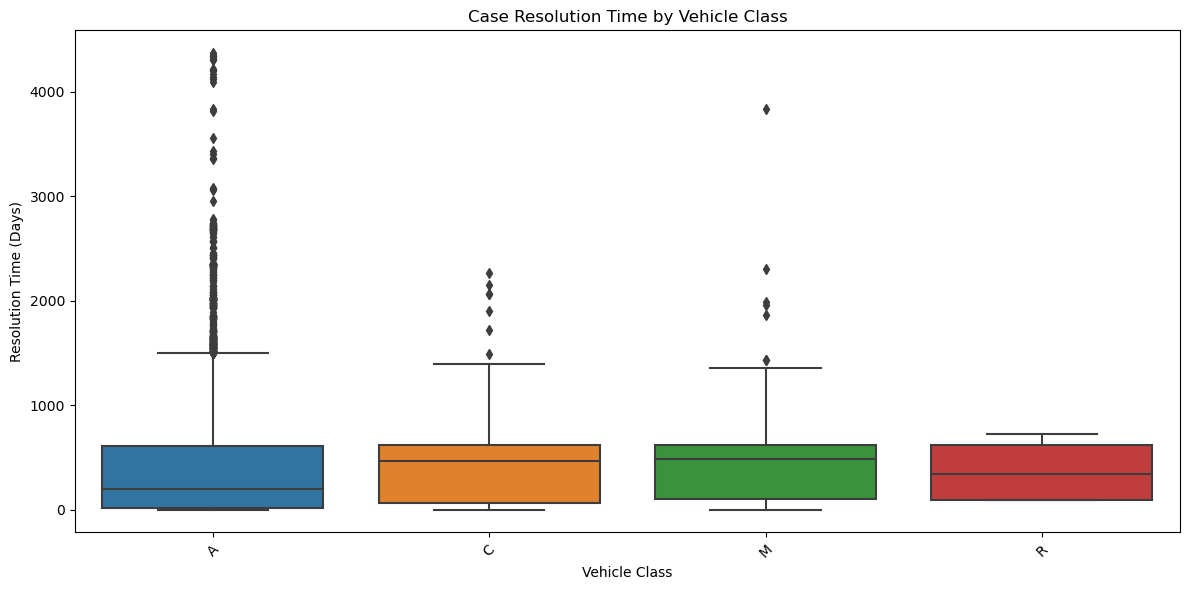

In [60]:
## Case Resolution Time

# Group by case ID and calculate the first and last event timestamps
case_times = log_df.groupby('case:concept:name').agg(
    case_start_date=('time:timestamp', 'min'),
    case_end_date=('time:timestamp', 'max')
).reset_index()

# Calculate the resolution time for each case
case_times['resolution_time'] = (case_times['case_end_date'] - case_times['case_start_date']).dt.days

# Plot resolution time distribution
plt.figure(figsize=(12, 6))
sns.histplot(case_times['resolution_time'], bins=30, kde=True)
plt.title("Case Resolution Time Distribution")
plt.xlabel("Resolution Time (Days)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# If 'vehicleClass' column exists, visualize case resolution time by vehicle class
if 'vehicleClass' in log_df.columns:
    case_times_with_class = case_times.merge(log_df[['case:concept:name', 'vehicleClass']].drop_duplicates(), on='case:concept:name', how='left')
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='vehicleClass', y='resolution_time', data=case_times_with_class)
    plt.title("Case Resolution Time by Vehicle Class")
    plt.xlabel("Vehicle Class")
    plt.ylabel("Resolution Time (Days)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()